In [1]:
!pip install pytorch-tabnet imbalanced-learn scikit-learn dask_ml


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 30.5 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 46.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 60.1 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 49.1 MB/s eta 0:00:0000:01m0:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.2 

In [11]:
import pandas as pd
import numpy as np
from dask_ml.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, label_binarize
from imblearn.over_sampling import SMOTE
import dask.dataframe as dd
from sklearn.feature_selection import mutual_info_classif
from dask_ml.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
import torch
from sklearn.metrics import (confusion_matrix, classification_report,
                             hamming_loss, f1_score, roc_curve, roc_auc_score,accuracy_score)
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
# -------------------
# Dask -> Pandas/Scikit-learn equivalents
# -------------------

# Dask ML StandardScaler -> scikit-learn StandardScaler
from sklearn.preprocessing import StandardScaler

# Dask DataFrame -> pandas DataFrame
import pandas as pd

# Dask-ML train_test_split -> scikit-learn train_test_split
from sklearn.model_selection import train_test_split

# LabelEncoder / label_binarize (same as before)
from sklearn.preprocessing import LabelEncoder, label_binarize

# SMOTE (same, works on pandas/numpy)
from imblearn.over_sampling import SMOTE

# Mutual information feature selection
from sklearn.feature_selection import mutual_info_classif


In [12]:
df=pd.read_csv("/kaggle/input/gotham/merged_dataset.csv")

/tmp/ipykernel_38/2048021531.py:1: DtypeWarning: Columns (14,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv("/kaggle/input/gotham/merged_dataset.csv")


In [4]:
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,frame.time,frame.len,frame.protocols,eth.src,eth.dst,ip.dst,ip.src,ip.flags,ip.ttl,ip.proto,...,tcp.dstport,tcp.flags,tcp.window_size_value,tcp.window_size_scalefactor,tcp.checksum,tcp.options,tcp.pdu.size,udp.srcport,udp.dstport,label
0,"Jan 14, 2025 18:40:22.447710000 GMT",67,eth:ethertype:ip:udp:dns,02:42:52:d7:fa:00,0c:6e:9c:16:00:00,192.168.0.2,192.168.18.17,0x02,64,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48322.0,53.0,Benign
1,"Jan 14, 2025 18:40:22.453402000 GMT",83,eth:ethertype:ip:udp:dns,0c:6e:9c:16:00:00,02:42:52:d7:fa:00,192.168.18.17,192.168.0.2,0x02,61,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,53.0,48322.0,Benign
2,"Jan 14, 2025 18:40:22.453507000 GMT",90,eth:ethertype:ip:udp:ntp,02:42:52:d7:fa:00,0c:6e:9c:16:00:00,192.168.0.3,192.168.18.17,0x02,64,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46343.0,123.0,Benign
3,"Jan 14, 2025 18:40:22.458119000 GMT",90,eth:ethertype:ip:udp:ntp,0c:6e:9c:16:00:00,02:42:52:d7:fa:00,192.168.18.17,192.168.0.3,0x02,61,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.0,46343.0,Benign
4,"Jan 14, 2025 18:40:22.560013000 GMT",76,eth:ethertype:ip:udp:dns,02:42:52:d7:fa:00,0c:6e:9c:16:00:00,192.168.0.2,192.168.18.17,0x02,64,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36848.0,53.0,Benign


In [13]:

# Count per label
label_counts = df['label'].value_counts()

# Find the median class count (reasonable target for balancing)
# You could also choose min(label_counts) if you want strict balancing
target_per_class = int(label_counts.median())

# In-place undersampling
balanced_chunks = []

for lbl, count in label_counts.items():
    # If class is larger than target, sample
    if count > target_per_class:
        sampled = df[df['label'] == lbl].sample(n=target_per_class, random_state=42)
    else:
        sampled = df[df['label'] == lbl]  # keep all for smaller classes
    balanced_chunks.append(sampled)

# Replace df with balanced dataset
df = pd.concat(balanced_chunks, ignore_index=True)

# Optional: shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check
print(df['label'].value_counts())
print("Balanced dataset shape:", df.shape)


label
Mirai UDP Flooding          43788
TCP Scan                    43788
Merlin TCP Flooding         43788
Mirai GRE Flooding          43788
Merlin ICMP Flooding        43788
CoAP Amplification          43788
Telnet Brute Force          43788
Mirai TCP Flooding          43788
Benign                      43788
Merlin UDP Flooding         29996
Merlin C&C Communication    29356
Ingress Tool Transfer       21587
Unknown                      7670
File Download                7196
UDP Scan                     4242
Mirai C&C Communication      1074
C&C Communication             528
Reporting                     450
Name: count, dtype: int64
Balanced dataset shape: (496191, 23)


In [14]:
import gc

In [15]:
del balanced_chunks
gc.collect()

0

In [16]:
# -------------------
# Drop unnecessary columns
# -------------------
df.drop(columns=['ip.checksum', 'tcp.checksum'], errors='ignore', inplace=True)

# -------------------
# Reset index FIRST
# -------------------
df.reset_index(drop=True, inplace=True)

# -------------------
# Time-based features
# -------------------
df['frame.time'] = pd.to_datetime(df['frame.time'], errors='coerce')
df['hour'] = df['frame.time'].dt.hour.fillna(-1).astype('int32')
df['minute'] = df['frame.time'].dt.minute.fillna(-1).astype('int32')
df['second'] = df['frame.time'].dt.second.fillna(-1).astype('int32')

# -------------------
# Protocol type indicators
# -------------------
df['is_tcp'] = df['tcp.srcport'].notnull().astype('int8') if 'tcp.srcport' in df.columns else 0
df['is_udp'] = df['udp.srcport'].notnull().astype('int8') if 'udp.srcport' in df.columns else 0

# -------------------
# Handle nulls in numeric columns safely
# -------------------
null_fill_cols = ['ip.tos','tcp.srcport','tcp.dstport','tcp.options',
                  'tcp.pdu.size','udp.srcport','udp.dstport']
for col in null_fill_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype('float32')

# -------------------
# Packet size features
# -------------------
df['total_bytes'] = df['frame.len'].fillna(0) if 'frame.len' in df.columns else 0
if 'tcp.window_size_value' in df.columns:
    df['tcp.window_size_value'] = df['tcp.window_size_value'].fillna(0)
if 'tcp.window_size_scalefactor' in df.columns:
    df['tcp.window_size_scalefactor'] = df['tcp.window_size_scalefactor'].fillna(0)
    df['src_dst_bytes_diff'] = df['tcp.window_size_value'] - df['tcp.window_size_scalefactor']

# -------------------
# TCP flags handling
# -------------------
if 'tcp.flags' in df.columns:
    flags_num = pd.to_numeric(df['tcp.flags'], errors='coerce').fillna(0).astype('int32')
    df['syn_flag'] = ((flags_num & 0x02) > 0).astype('int8')
    df['ack_flag'] = ((flags_num & 0x10) > 0).astype('int8')
    del flags_num  # free memory
    df.drop(columns=['tcp.flags'], inplace=True)

# -------------------
# Frequency encoding for IP/MAC addresses
# -------------------
ip_cols = ['ip.src', 'ip.dst', 'eth.src', 'eth.dst']
for col in ip_cols:
    if col in df.columns:
        freq_map = df[col].value_counts()
        df[col + '_freq'] = df[col].map(freq_map).fillna(0).astype('float32')
        df.drop(columns=[col], inplace=True)  # drop original to save RAM

# -------------------
# Frequency encode other categorical columns
# -------------------
cat_cols = ['frame.protocols', 'ip.flags']
for col in cat_cols:
    if col in df.columns:
        freq_map = df[col].value_counts()
        df[col + '_freq'] = df[col].map(freq_map).fillna(0).astype('float32')
        df.drop(columns=[col], inplace=True)  # drop original

# -------------------
# Drop time column
# -------------------
if 'frame.time' in df.columns:
    df.drop(columns=['frame.time'], inplace=True)

# -------------------
# Fill any remaining nulls in numeric columns
# -------------------
num_cols = df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
for col in num_cols:
    df[col].fillna(0, inplace=True)

# -------------------
# Summary
# -------------------
print("Feature engineering completed successfully!")
print(f"Number of columns: {len(df.columns)}")
print(f"Columns: {list(df.columns)}")


Feature engineering completed successfully!
Number of columns: 28
Columns: ['frame.len', 'ip.ttl', 'ip.proto', 'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.options', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport', 'label', 'hour', 'minute', 'second', 'is_tcp', 'is_udp', 'total_bytes', 'src_dst_bytes_diff', 'syn_flag', 'ack_flag', 'ip.src_freq', 'ip.dst_freq', 'eth.src_freq', 'eth.dst_freq', 'frame.protocols_freq', 'ip.flags_freq']


/tmp/ipykernel_38/796753243.py:85: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


In [17]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle

print("\n=== Encoding Labels ===")

# Reuse the column variable to avoid extra copies
labels = df['label']

# Initialize and fit LabelEncoder
le = LabelEncoder()
le.fit(labels)

# Create mapping dictionary
label_mapping = {label: int(idx) for idx, label in enumerate(le.classes_)}
print(f"Label mapping: {label_mapping}")

# Apply mapping directly to df in-place
df['label_encoded'] = labels.map(label_mapping).fillna(-1).astype('int32')


# Save encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print(f"Label classes: {le.classes_}")
print(f"Number of classes: {len(le.classes_)}")
print("Label encoding complete!")



=== Encoding Labels ===
Label mapping: {'Benign': 0, 'C&C Communication': 1, 'CoAP Amplification': 2, 'File Download': 3, 'Ingress Tool Transfer': 4, 'Merlin C&C Communication': 5, 'Merlin ICMP Flooding': 6, 'Merlin TCP Flooding': 7, 'Merlin UDP Flooding': 8, 'Mirai C&C Communication': 9, 'Mirai GRE Flooding': 10, 'Mirai TCP Flooding': 11, 'Mirai UDP Flooding': 12, 'Reporting': 13, 'TCP Scan': 14, 'Telnet Brute Force': 15, 'UDP Scan': 16, 'Unknown': 17}
Label classes: ['Benign' 'C&C Communication' 'CoAP Amplification' 'File Download'
 'Ingress Tool Transfer' 'Merlin C&C Communication' 'Merlin ICMP Flooding'
 'Merlin TCP Flooding' 'Merlin UDP Flooding' 'Mirai C&C Communication'
 'Mirai GRE Flooding' 'Mirai TCP Flooding' 'Mirai UDP Flooding'
 'Reporting' 'TCP Scan' 'Telnet Brute Force' 'UDP Scan' 'Unknown']
Number of classes: 18
Label encoding complete!


In [18]:
y = df['label_encoded']
X = df.drop(columns=['label','label_encoded'])

In [20]:
X=X.astype("float32")

In [21]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [25]:
tabnet_clf = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='sparsemax',
    scheduler_params={"step_size":10, "gamma":0.9},  # gradual LR decay
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [27]:
tabnet_clf.fit(
    X_train=X_train.values, y_train=y_train,
    max_epochs=20,
    batch_size=512,          # smaller batch size → more gradient updates
    virtual_batch_size=64
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.98816 |  0:00:44s
epoch 1  | loss: 0.14527 |  0:01:27s
epoch 2  | loss: 0.09785 |  0:02:10s
epoch 3  | loss: 0.06204 |  0:02:53s
epoch 4  | loss: 0.06465 |  0:03:36s
epoch 5  | loss: 0.04642 |  0:04:19s
epoch 6  | loss: 0.03796 |  0:05:02s
epoch 7  | loss: 0.03038 |  0:05:44s
epoch 8  | loss: 0.02664 |  0:06:27s
epoch 9  | loss: 0.0232  |  0:07:09s
epoch 10 | loss: 0.02027 |  0:07:52s
epoch 11 | loss: 0.0193  |  0:08:35s
epoch 12 | loss: 0.01793 |  0:09:18s
epoch 13 | loss: 0.01573 |  0:10:00s
epoch 14 | loss: 0.01505 |  0:10:43s
epoch 15 | loss: 0.01341 |  0:11:24s
epoch 16 | loss: 0.01304 |  0:12:05s
epoch 17 | loss: 0.01182 |  0:12:45s
epoch 18 | loss: 0.01096 |  0:13:25s
epoch 19 | loss: 0.01008 |  0:14:06s


In [31]:
X_test_np = X_test.values
y_test_np = y_test.values

In [32]:
y_pred = tabnet_clf.predict(X_test.values)

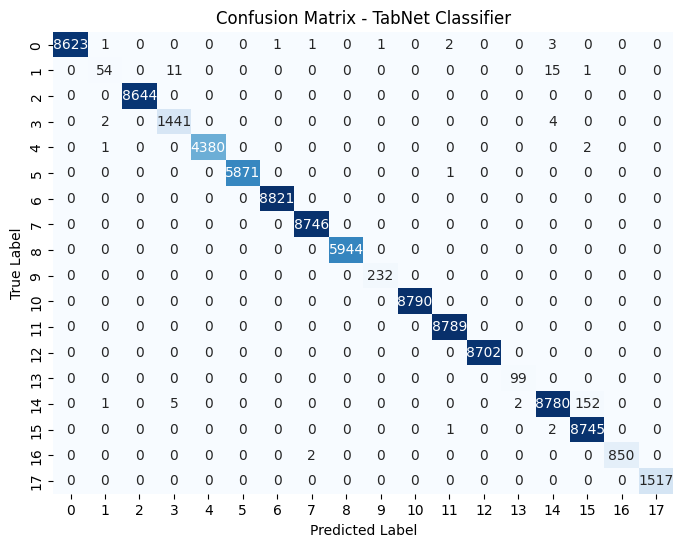

In [33]:
cm = confusion_matrix(y_test_np, y_pred)



# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - TabNet Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [35]:
# Step 3: Print Metrics
print("\n🔹 Classification Report:")
print(classification_report(y_test_np, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_test_np, y_pred):.4f}")


🔹 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8632
           1       0.92      0.67      0.77        81
           2       1.00      1.00      1.00      8644
           3       0.99      1.00      0.99      1447
           4       1.00      1.00      1.00      4383
           5       1.00      1.00      1.00      5872
           6       1.00      1.00      1.00      8821
           7       1.00      1.00      1.00      8746
           8       1.00      1.00      1.00      5944
           9       1.00      1.00      1.00       232
          10       1.00      1.00      1.00      8790
          11       1.00      1.00      1.00      8789
          12       1.00      1.00      1.00      8702
          13       0.98      1.00      0.99        99
          14       1.00      0.98      0.99      8940
          15       0.98      1.00      0.99      8748
          16       1.00      1.00      1.00       852
 

In [36]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

# Calculate key metrics
acc = accuracy_score(y_test_np, y_pred)
prec_macro = precision_score(y_test_np, y_pred, average='macro')
rec_macro  = recall_score(y_test_np, y_pred, average='macro')
f1_macro = f1_score(y_test_np, y_pred, average='macro')
f1_weighted = f1_score(y_test_np, y_pred, average='weighted')
hloss = hamming_loss(y_test_np, y_pred)

print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 Macro Precision: {prec_macro:.4f}")
print(f"🎯 Macro Recall: {rec_macro:.4f}")
print(f"🎯 Macro F1-Score: {f1_macro:.4f}")
print(f"🎯 Weighted F1-Score: {f1_weighted:.4f}")
print(f"⚡ Hamming Loss: {hloss:.6f}")


✅ Accuracy: 0.9979
🎯 Macro Precision: 0.9922
🎯 Macro Recall: 0.9800
🎯 Macro F1-Score: 0.9850
🎯 Weighted F1-Score: 0.9978
⚡ Hamming Loss: 0.002126


🧭 ROC-AUC (macro-average): 1.0000


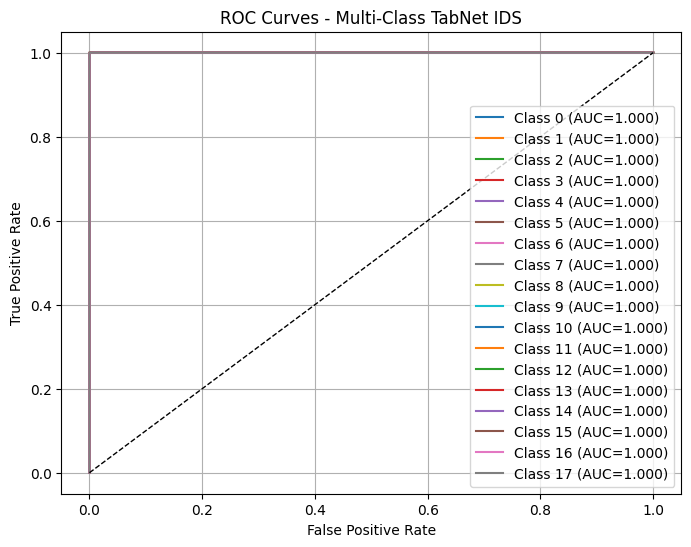

In [37]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels for multi-class ROC
classes = np.unique(y_test_np)
y_test_bin = label_binarize(y_test_np, classes=classes)
y_pred_prob = tabnet_clf.predict_proba(X_test_np)

# Compute ROC AUC per class
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print(f"🧭 ROC-AUC (macro-average): {roc_auc:.4f}")

# Plot ROC Curves for each class
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC={auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curves - Multi-Class TabNet IDS')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


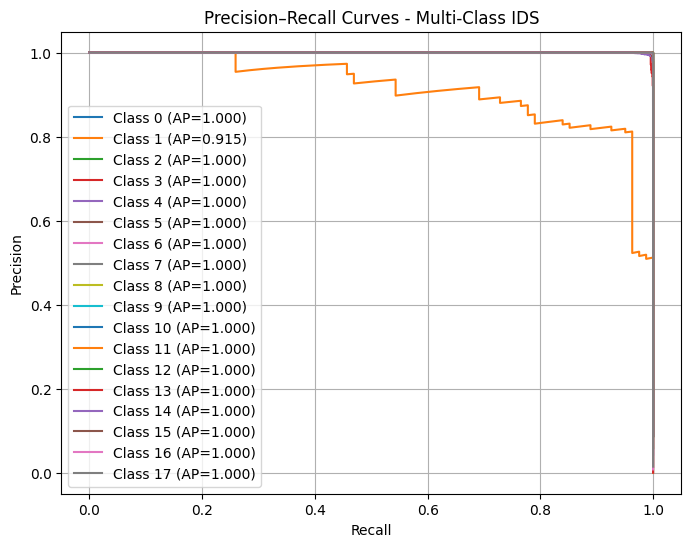

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_prec = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {cls} (AP={avg_prec:.3f})')

plt.title('Precision–Recall Curves - Multi-Class IDS')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid(True)
plt.show()


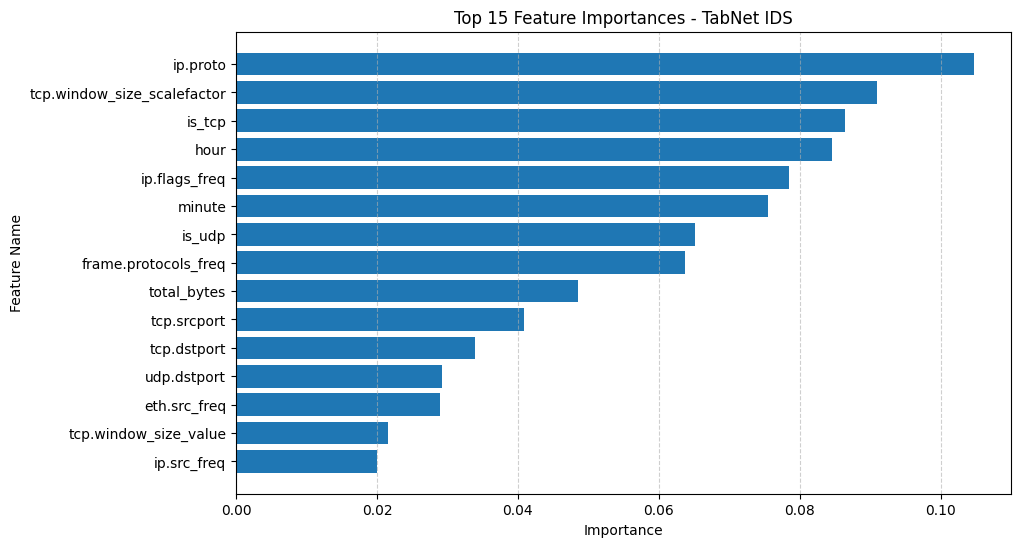

In [41]:
# Built-in interpretability (TabNet Attention Masks)
feature_importances = tabnet_clf.feature_importances_

# Sort and display
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = [X.columns[i] for i in sorted_idx[:15]]

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], feature_importances[sorted_idx[:15]][::-1])
plt.title("Top 15 Feature Importances - TabNet IDS")
plt.xlabel("Importance")
plt.ylabel("Feature Name")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [42]:
import pandas as pd

# Create a DataFrame to analyze wrong predictions
error_df = pd.DataFrame({
    'True_Label': y_test_np,
    'Predicted_Label': y_pred
})

misclassified = error_df[error_df['True_Label'] != error_df['Predicted_Label']]
print(f"⚠️ Total Misclassifications: {len(misclassified)}")
print("\nSample Misclassifications:")
print(misclassified.head(10))


⚠️ Total Misclassifications: 211

Sample Misclassifications:
      True_Label  Predicted_Label
1033          14               15
1129          14               15
1362          14               15
1451          14               15
2044          14               15
2093          14               15
2648          14               15
2969          14               15
4016          14               15
4354           0                1


In [39]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test_np, y_pred)
print(f"📏 Matthews Correlation Coefficient (MCC): {mcc:.4f}")


📏 Matthews Correlation Coefficient (MCC): 0.9977


In [40]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test_np, y_pred)
print(f"🧩 Cohen’s Kappa Score: {kappa:.4f}")


🧩 Cohen’s Kappa Score: 0.9977


In [43]:
results_summary = {
    'Accuracy': acc,
    'Macro_Precision': prec_macro,
    'Macro_Recall': rec_macro,
    'Macro_F1': f1_macro,
    'Weighted_F1': f1_weighted,
    'ROC_AUC': roc_auc,
    'MCC': mcc,
    'Cohen_Kappa': kappa,
    'Hamming_Loss': hloss
}

print("\n📘 Evaluation Summary (TabNet IDS):")
for metric, value in results_summary.items():
    print(f"{metric:<20}: {value:.4f}")



📘 Evaluation Summary (TabNet IDS):
Accuracy            : 0.9979
Macro_Precision     : 0.9922
Macro_Recall        : 0.9800
Macro_F1            : 0.9850
Weighted_F1         : 0.9978
ROC_AUC             : 1.0000
MCC                 : 0.9977
Cohen_Kappa         : 0.9977
Hamming_Loss        : 0.0021


In [3]:
df = dd.read_csv(
    "/kaggle/input/gotham/merged_dataset.csv",
    dtype={
        'tcp.checksum': 'object',
        'tcp.flags': 'object',
        'tcp.options': 'object'
    },
    assume_missing=True,  # allows mixed types
    blocksize="256MB"      # adjust based on RAM
)
df

,frame.time,frame.len,frame.protocols,eth.src,eth.dst,ip.dst,ip.src,ip.flags,ip.ttl,ip.proto,ip.checksum,ip.tos,tcp.srcport,tcp.dstport,tcp.flags,tcp.window_size_value,tcp.window_size_scalefactor,tcp.checksum,tcp.options,tcp.pdu.size,udp.srcport,udp.dstport,label
npartitions=27,,,,,,,,,,,,,,,,,,,,,,,
,string,float64,string,string,string,string,string,string,float64,float64,string,float64,float64,float64,string,float64,float64,string,string,float64,float64,float64,string
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
df.columns

Index(['frame.time', 'frame.len', 'frame.protocols', 'eth.src', 'eth.dst',
       'ip.dst', 'ip.src', 'ip.flags', 'ip.ttl', 'ip.proto', 'ip.checksum',
       'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.flags',
       'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.checksum',
       'tcp.options', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport', 'label'],
      dtype='object')

In [5]:
df.dtypes

frame.time                     string[pyarrow]
frame.len                              float64
frame.protocols                string[pyarrow]
eth.src                        string[pyarrow]
eth.dst                        string[pyarrow]
ip.dst                         string[pyarrow]
ip.src                         string[pyarrow]
ip.flags                       string[pyarrow]
ip.ttl                                 float64
ip.proto                               float64
ip.checksum                    string[pyarrow]
ip.tos                                 float64
tcp.srcport                            float64
tcp.dstport                            float64
tcp.flags                      string[pyarrow]
tcp.window_size_value                  float64
tcp.window_size_scalefactor            float64
tcp.checksum                   string[pyarrow]
tcp.options                    string[pyarrow]
tcp.pdu.size                           float64
udp.srcport                            float64
udp.dstport  

In [6]:
attack_counts = df['label'].value_counts().compute()
print(attack_counts)

label
CoAP Amplification            274837
Merlin TCP Flooding           120000
Reporting                        450
Unknown                         7670
Telnet Brute Force            227649
Mirai GRE Flooding           5911401
UDP Scan                        4242
Mirai UDP Flooding           8897895
File Download                   7196
C&C Communication                528
TCP Scan                      737764
Merlin C&C Communication       29356
Ingress Tool Transfer          21587
Benign                      12256883
Merlin UDP Flooding            29996
Mirai C&C Communication         1074
Mirai TCP Flooding           6548173
Merlin ICMP Flooding           57580
Name: count, dtype: int64[pyarrow]


In [7]:
# Drop unnecessary columns
df = df.drop(columns=['ip.checksum', 'tcp.checksum'], errors='ignore')

# Reset index FIRST before any transformations
print("Resetting index...")
df = df.reset_index(drop=True)

# -------------------
# Time-based features
# -------------------
df['frame.time'] = dd.to_datetime(df['frame.time'], errors='coerce')
df['hour'] = df['frame.time'].dt.hour.fillna(-1).astype('int32')
df['minute'] = df['frame.time'].dt.minute.fillna(-1).astype('int32')
df['second'] = df['frame.time'].dt.second.fillna(-1).astype('int32')

# -------------------
# Protocol type indicators
# -------------------
df['is_tcp'] = df['tcp.srcport'].notnull().astype('int8')
df['is_udp'] = df['udp.srcport'].notnull().astype('int8')

# -------------------
# Handle nulls in numeric columns safely
# -------------------
null_fill_cols = ['ip.tos','tcp.srcport','tcp.dstport','tcp.options',
                  'tcp.pdu.size','udp.srcport','udp.dstport']
for col in null_fill_cols:
    if col in df.columns:
        df[col] = dd.to_numeric(df[col], errors='coerce').fillna(0).astype('float32')

# -------------------
# Packet size features
# -------------------
df['total_bytes'] = df['frame.len'].fillna(0)
if 'tcp.window_size_value' in df.columns:
    df['tcp.window_size_value'] = df['tcp.window_size_value'].fillna(0)
if 'tcp.window_size_scalefactor' in df.columns:
    df['tcp.window_size_scalefactor'] = df['tcp.window_size_scalefactor'].fillna(0)
    df['src_dst_bytes_diff'] = df['tcp.window_size_value'] - df['tcp.window_size_scalefactor']

# -------------------
# TCP flags handling
# -------------------
if 'tcp.flags' in df.columns:
    df['tcp.flags_num'] = dd.to_numeric(df['tcp.flags'], errors='coerce').fillna(0).astype('int32')
    df['syn_flag'] = ((df['tcp.flags_num'] & 0x02) > 0).astype('int8')
    df['ack_flag'] = ((df['tcp.flags_num'] & 0x10) > 0).astype('int8')
    df = df.drop(columns=['tcp.flags_num', 'tcp.flags'])

# -------------------
# Frequency encoding for IP/MAC addresses
# -------------------
ip_cols = ['ip.src', 'ip.dst', 'eth.src', 'eth.dst']
for col in ip_cols:
    if col in df.columns:
        freq_map = df[col].value_counts().compute()
        df[col + '_freq'] = df[col].map_partitions(
            lambda x: x.map(freq_map).fillna(0), 
            meta=('freq', 'f4')
        )

# -------------------
# Frequency encode other categorical columns
# -------------------
cat_cols = ['frame.protocols', 'ip.flags']
for col in cat_cols:
    if col in df.columns:
        freq_map = df[col].value_counts().compute()
        df[col + '_freq'] = df[col].map_partitions(
            lambda x: x.map(freq_map).fillna(0), 
            meta=(col + '_freq', 'f4')
        )

# -------------------
# Drop original categorical columns and time
# -------------------
drop_cols = ['frame.time', 'ip.src', 'ip.dst', 'eth.src', 'eth.dst', 
             'frame.protocols', 'ip.flags']
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors='ignore')

# -------------------
# Fill any remaining nulls in numeric columns
# -------------------
num_cols = df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
for col in num_cols:
    df[col] = df[col].fillna(0)

print("Feature engineering completed successfully!")
# DON'T compute here - just show column info
print(f"Number of columns: {len(df.columns)}")
print(f"Columns: {list(df.columns)}")

Resetting index...
Feature engineering completed successfully!
Number of columns: 28
Columns: ['frame.len', 'ip.ttl', 'ip.proto', 'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.options', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport', 'label', 'hour', 'minute', 'second', 'is_tcp', 'is_udp', 'total_bytes', 'src_dst_bytes_diff', 'syn_flag', 'ack_flag', 'ip.src_freq', 'ip.dst_freq', 'eth.src_freq', 'eth.dst_freq', 'frame.protocols_freq', 'ip.flags_freq']


In [8]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import pickle

print("\n=== Encoding Labels ===")

# Use dictionary mapping to avoid index issues
labels_pd = df['label'].compute()
le = LabelEncoder()
le.fit(labels_pd)

# Create mapping dictionary
label_mapping = {label: int(idx) for idx, label in enumerate(le.classes_)}
print(f"Label mapping: {label_mapping}")

# Apply mapping
df['label_encoded'] = df['label'].map_partitions(
    lambda x: x.map(label_mapping).fillna(-1).astype('int32'),
    meta=('label_encoded', 'int32')
)

# Save encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)

print(f"Label classes: {le.classes_}")
print(f"Number of classes: {len(le.classes_)}")

# Drop original label


print("Label encoding complete!")


=== Encoding Labels ===
Label mapping: {'Benign': 0, 'C&C Communication': 1, 'CoAP Amplification': 2, 'File Download': 3, 'Ingress Tool Transfer': 4, 'Merlin C&C Communication': 5, 'Merlin ICMP Flooding': 6, 'Merlin TCP Flooding': 7, 'Merlin UDP Flooding': 8, 'Mirai C&C Communication': 9, 'Mirai GRE Flooding': 10, 'Mirai TCP Flooding': 11, 'Mirai UDP Flooding': 12, 'Reporting': 13, 'TCP Scan': 14, 'Telnet Brute Force': 15, 'UDP Scan': 16, 'Unknown': 17}
Label classes: ['Benign' 'C&C Communication' 'CoAP Amplification' 'File Download'
 'Ingress Tool Transfer' 'Merlin C&C Communication' 'Merlin ICMP Flooding'
 'Merlin TCP Flooding' 'Merlin UDP Flooding' 'Mirai C&C Communication'
 'Mirai GRE Flooding' 'Mirai TCP Flooding' 'Mirai UDP Flooding'
 'Reporting' 'TCP Scan' 'Telnet Brute Force' 'UDP Scan' 'Unknown']
Number of classes: 18
Label encoding complete!


In [9]:
# NOW it's safe to compute
print("Computing null counts...")
null_counts = df.isnull().sum().compute()
print(f"\nNull counts:\n{null_counts[null_counts > 0]}")

print("\nFinal DataFrame Info:")
print(f"Shape: {df.compute().shape}")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst few rows:\n{df.head()}")

Computing null counts...

Null counts:
Series([], dtype: int64)

Final DataFrame Info:
Shape: (35134281, 29)
Columns: ['frame.len', 'ip.ttl', 'ip.proto', 'ip.tos', 'tcp.srcport', 'tcp.dstport', 'tcp.window_size_value', 'tcp.window_size_scalefactor', 'tcp.options', 'tcp.pdu.size', 'udp.srcport', 'udp.dstport', 'label', 'hour', 'minute', 'second', 'is_tcp', 'is_udp', 'total_bytes', 'src_dst_bytes_diff', 'syn_flag', 'ack_flag', 'ip.src_freq', 'ip.dst_freq', 'eth.src_freq', 'eth.dst_freq', 'frame.protocols_freq', 'ip.flags_freq', 'label_encoded']

First few rows:
   frame.len  ip.ttl  ip.proto  ip.tos  tcp.srcport  tcp.dstport  \
0       67.0    64.0      17.0     0.0          0.0          0.0   
1       83.0    61.0      17.0     0.0          0.0          0.0   
2       90.0    64.0      17.0     0.0          0.0          0.0   
3       90.0    61.0      17.0     0.0          0.0          0.0   
4       76.0    64.0      17.0     0.0          0.0          0.0   

   tcp.window_size_value 

In [10]:
df.dtypes

frame.len                              float64
ip.ttl                                 float64
ip.proto                               float64
ip.tos                                 float32
tcp.srcport                            float32
tcp.dstport                            float32
tcp.window_size_value                  float64
tcp.window_size_scalefactor            float64
tcp.options                            float32
tcp.pdu.size                           float32
udp.srcport                            float32
udp.dstport                            float32
label                          string[pyarrow]
hour                                     int32
minute                                   int32
second                                   int32
is_tcp                                    int8
is_udp                                    int8
total_bytes                            float64
src_dst_bytes_diff                     float64
syn_flag                                  int8
ack_flag     

In [11]:
y = df['label_encoded']
X = df.drop(columns=['label','label_encoded'])

In [17]:
X=X.astype("float64")

In [18]:
X.dtypes

frame.len                      float64
ip.ttl                         float64
ip.proto                       float64
ip.tos                         float64
tcp.srcport                    float64
tcp.dstport                    float64
tcp.window_size_value          float64
tcp.window_size_scalefactor    float64
tcp.options                    float64
tcp.pdu.size                   float64
udp.srcport                    float64
udp.dstport                    float64
hour                           float64
minute                         float64
second                         float64
is_tcp                         float64
is_udp                         float64
total_bytes                    float64
src_dst_bytes_diff             float64
syn_flag                       float64
ack_flag                       float64
ip.src_freq                    float64
ip.dst_freq                    float64
eth.src_freq                   float64
eth.dst_freq                   float64
frame.protocols_freq     

In [20]:
scaler = StandardScaler()
X = scaler.fit_transform(X)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

/usr/local/lib/python3.11/dist-packages/dask_ml/model_selection/_split.py:464: FutureWarning: The default value for 'shuffle' must be specified when splitting DataFrames. In the future DataFrames will automatically be shuffled within blocks prior to splitting. Specify 'shuffle=True' to adopt the future behavior now, or 'shuffle=False' to retain the previous behavior.
  warnings.warn(


In [22]:
tabnet_clf = TabNetClassifier(
    n_d=32,
    n_a=32,
    n_steps=5,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),
    mask_type='sparsemax',
    scheduler_params={"step_size":10, "gamma":0.9},  # gradual LR decay
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [23]:
samples = []
N = 500  # or whatever your N value is

for label_name in attack_counts.index:
    # Filter only this label
    label_df = df[df['label'] == label_name]
    
    # Get actual count for this label
    actual_count = attack_counts[label_name]
    sample_count = min(N, actual_count)
    
    # Calculate fraction to sample
    frac = sample_count / actual_count
    
    # Sample using fraction (safer for Dask)
    sampled = label_df.sample(frac=frac, random_state=42)
    samples.append(sampled)
    
    print(f"Sampled {sample_count} from {label_name} ({actual_count} total)")

# Combine all small samples
balanced_df = dd.concat(samples)

# Trigger compute to bring small dataset to memory
balanced_df = balanced_df.compute()

# Separate features and labels
X_train_dask = balanced_df.drop(['label_encoded',"label"], axis=1)
y_train_dask = balanced_df['label_encoded']

for col in X_train_dask.columns:
    if 'pyarrow' in str(X_train_dask[col].dtype):
        X_train_dask[col] = X_train_dask[col].astype('int64')

X_np = X_train_dask.astype('float32')
y_np = y_train_dask.astype('int64')

X_np = X_train_dask.to_numpy()
y_np = y_train_dask.to_numpy()



print(f"\nFinal balanced dataset shape: {X_np.shape}")
print(f"Label distribution:\n{pd.Series(y_np).value_counts()}")

Sampled 500 from CoAP Amplification (274837 total)
Sampled 500 from Merlin TCP Flooding (120000 total)
Sampled 450 from Reporting (450 total)
Sampled 500 from Unknown (7670 total)
Sampled 500 from Telnet Brute Force (227649 total)
Sampled 500 from Mirai GRE Flooding (5911401 total)
Sampled 500 from UDP Scan (4242 total)
Sampled 500 from Mirai UDP Flooding (8897895 total)
Sampled 500 from File Download (7196 total)
Sampled 500 from C&C Communication (528 total)
Sampled 500 from TCP Scan (737764 total)
Sampled 500 from Merlin C&C Communication (29356 total)
Sampled 500 from Ingress Tool Transfer (21587 total)
Sampled 500 from Benign (12256883 total)
Sampled 500 from Merlin UDP Flooding (29996 total)
Sampled 500 from Mirai C&C Communication (1074 total)
Sampled 500 from Mirai TCP Flooding (6548173 total)
Sampled 500 from Merlin ICMP Flooding (57580 total)

Final balanced dataset shape: (8942, 27)
Label distribution:
11    502
10    501
6     500
2     500
15    500
17    500
3     500
12 

In [24]:
print(X_train_dask.dtypes)

frame.len                      float64
ip.ttl                         float64
ip.proto                       float64
ip.tos                         float32
tcp.srcport                    float32
tcp.dstport                    float32
tcp.window_size_value          float64
tcp.window_size_scalefactor    float64
tcp.options                    float32
tcp.pdu.size                   float32
udp.srcport                    float32
udp.dstport                    float32
hour                             int32
minute                           int32
second                           int32
is_tcp                            int8
is_udp                            int8
total_bytes                    float64
src_dst_bytes_diff             float64
syn_flag                          int8
ack_flag                          int8
ip.src_freq                      int64
ip.dst_freq                      int64
eth.src_freq                     int64
eth.dst_freq                     int64
frame.protocols_freq     

In [25]:
tabnet_clf.fit(
    X_train=X_np, y_train=y_np,
    max_epochs=10,
    batch_size=256,          # smaller batch size → more gradient updates
    virtual_batch_size=64
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 5.44707 |  0:00:02s
epoch 1  | loss: 3.84269 |  0:00:03s
epoch 2  | loss: 2.90463 |  0:00:04s
epoch 3  | loss: 2.46149 |  0:00:06s
epoch 4  | loss: 2.19852 |  0:00:07s
epoch 5  | loss: 1.91203 |  0:00:09s
epoch 6  | loss: 1.72299 |  0:00:10s
epoch 7  | loss: 1.50488 |  0:00:11s
epoch 8  | loss: 1.27869 |  0:00:13s
epoch 9  | loss: 1.11531 |  0:00:14s


In [ ]:
for i in tqdm(range(X_train.npartitions), desc="Training on partitions"):
    X_batch = X_train.get_partition(i).compute()
    y_batch = y_train.get_partition(i).compute()

    
    # Safety check: skip empty partitions
    if len(X_batch) == 0:
        continue
    
    # Convert to numpy arrays for TabNet
    X_np = X_batch.to_numpy()
    y_np = y_batch.to_numpy()
    
    # Ensure y_np is 1D
    y_np = np.ravel(y_np)

    # Continue learning from pretrained weights
    tabnet_clf.fit(
        X_train=X_np, y_train=y_np,
        max_epochs=10,
        patience=5,
        batch_size=1024,
        virtual_batch_size=128,
        warm_start=True  # Always continue from existing weights
    )

Training on partitions:   0%|          | 0/27 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.32883 |  0:01:22s
epoch 1  | loss: 0.08343 |  0:02:45s
epoch 2  | loss: 0.06617 |  0:04:07s
epoch 3  | loss: 0.05314 |  0:05:29s
epoch 4  | loss: 0.04338 |  0:06:51s
epoch 5  | loss: 0.04115 |  0:08:14s
epoch 6  | loss: 0.03974 |  0:09:36s
epoch 7  | loss: 0.03917 |  0:10:58s
epoch 8  | loss: 0.03668 |  0:12:20s
epoch 9  | loss: 0.035   |  0:13:42s


Training on partitions:   4%|▎         | 1/27 [17:45<7:41:30, 1065.03s/it]/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


epoch 0  | loss: 0.3697  |  0:01:23s
epoch 1  | loss: 0.00054 |  0:02:47s
epoch 2  | loss: 0.0004  |  0:04:11s
epoch 3  | loss: 0.00032 |  0:05:35s


In [ ]:
X_test_np = X_test.compute().to_numpy()
y_test_np = np.ravel(y_test.compute().to_numpy())

In [ ]:
y_pred = tabnet_clf.predict(X_test_np)

In [ ]:
cm = confusion_matrix(y_test_np, y_pred)



# Step 4: Visualize Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - TabNet Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
# Step 3: Print Metrics
print("\n🔹 Classification Report:")
print(classification_report(y_test_np, y_pred))
print(f"✅ Accuracy: {accuracy_score(y_test_np, y_pred):.4f}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss

# Calculate key metrics
acc = accuracy_score(y_test_np, y_pred)
prec_macro = precision_score(y_test_np, y_pred, average='macro')
rec_macro  = recall_score(y_test_np, y_pred, average='macro')
f1_macro = f1_score(y_test_np, y_pred, average='macro')
f1_weighted = f1_score(y_test_np, y_pred, average='weighted')
hloss = hamming_loss(y_test_np, y_pred)

print(f"✅ Accuracy: {acc:.4f}")
print(f"🎯 Macro Precision: {prec_macro:.4f}")
print(f"🎯 Macro Recall: {rec_macro:.4f}")
print(f"🎯 Macro F1-Score: {f1_macro:.4f}")
print(f"🎯 Weighted F1-Score: {f1_weighted:.4f}")
print(f"⚡ Hamming Loss: {hloss:.6f}")


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
import numpy as np

# Binarize labels for multi-class ROC
classes = np.unique(y_test_np)
y_test_bin = label_binarize(y_test_np, classes=classes)
y_pred_prob = tabnet_clf.predict_proba(X_test_np)

# Compute ROC AUC per class
roc_auc = roc_auc_score(y_test_bin, y_pred_prob, average='macro', multi_class='ovr')
print(f"🧭 ROC-AUC (macro-average): {roc_auc:.4f}")

# Plot ROC Curves for each class
plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {cls} (AUC={auc(fpr, tpr):.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.title('ROC Curves - Multi-Class TabNet IDS')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(8, 6))
for i, cls in enumerate(classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_prob[:, i])
    avg_prec = average_precision_score(y_test_bin[:, i], y_pred_prob[:, i])
    plt.plot(recall, precision, label=f'Class {cls} (AP={avg_prec:.3f})')

plt.title('Precision–Recall Curves - Multi-Class IDS')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='best')
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import matthews_corrcoef

mcc = matthews_corrcoef(y_test_np, y_pred)
print(f"📏 Matthews Correlation Coefficient (MCC): {mcc:.4f}")


In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(y_test_np, y_pred)
print(f"🧩 Cohen’s Kappa Score: {kappa:.4f}")


In [ ]:
# Built-in interpretability (TabNet Attention Masks)
feature_importances = tabnet_clf.feature_importances_

# Sort and display
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = [X.columns[i] for i in sorted_idx[:15]]

plt.figure(figsize=(10, 6))
plt.barh(top_features[::-1], feature_importances[sorted_idx[:15]][::-1])
plt.title("Top 15 Feature Importances - TabNet IDS")
plt.xlabel("Importance")
plt.ylabel("Feature Name")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


In [ ]:
import pandas as pd

# Create a DataFrame to analyze wrong predictions
error_df = pd.DataFrame({
    'True_Label': y_test_np,
    'Predicted_Label': y_pred
})

misclassified = error_df[error_df['True_Label'] != error_df['Predicted_Label']]
print(f"⚠️ Total Misclassifications: {len(misclassified)}")
print("\nSample Misclassifications:")
print(misclassified.head(10))


In [ ]:
results_summary = {
    'Accuracy': acc,
    'Macro_Precision': prec_macro,
    'Macro_Recall': rec_macro,
    'Macro_F1': f1_macro,
    'Weighted_F1': f1_weighted,
    'ROC_AUC': roc_auc,
    'MCC': mcc,
    'Cohen_Kappa': kappa,
    'Hamming_Loss': hloss
}

print("\n📘 Evaluation Summary (TabNet IDS):")
for metric, value in results_summary.items():
    print(f"{metric:<20}: {value:.4f}")
